## Processing Sensor Data from Catalina Jemez CZO BGZOB Pit 4
- Marc Berghouse 9/19/2020: original format
- Zach Perzan 9/23/2020: improved format and working PRISM concat

This array includes:
- apogee_SO110
- Vaisala_GMM220
- DecagonMPS6
- Decagon5TE
- Vertical redox prodes from Paleo Terra

Issues:
- I'm not sure which water potential values are unrealistic


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def plot_cols(column_list, ylabel=''):
    """Plot columns from df. Columns to plot must be in
    column_list."""
    
    n = len(column_list)

    fig, ax = plt.subplots(n, figsize=(10,3*n), tight_layout=True, sharex=True)

    for i, col in enumerate(column_list):
        ax[i].plot(df.index, df[col], label=col)
        ax[i].legend(loc='upper right')
        ax[i].set(ylabel=ylabel)
        
    return fig, ax

def remove_spikes(df, column, window=7, threshold=1):
    """Given a dataframe and column, remove values that are different 
    from the rolling median. For example, with window=5 and threshold=1000 ppm,
    values that are more than 1000 ppm off from the 5-value rolling median will
    be set to NaN.
    
    params: 
        df [dataframe]: dataframe in which the 
        column [str]: name of the column to modify within df
        window [int]: number of records over which to take the median
        threshold [float]: threshold difference above which values are 
            removed (set to NaN)
            
    returns:
        nothing (modifies data in place)
    """
    
    data = df[column].copy()
    
    rollmed = data.rolling(window).median()
    diff = (data - rollmed).abs()
    mask = diff > threshold
    data[mask] = np.nan
    
    df[column] = data

In [2]:
infiles = ["../../raw_data/Catalina-Jemez/BGZOB_Pit4/BGZOB4_co2o2_2014.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit4/BGZOB4_co2o2_2015.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit4/BGZOB4_co2o2_2016.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit4/BGZOB4_co2o2_2017.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit4/BGZOB4_soilMTP_2014.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit4/BGZOB4_soilMTP_2015.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit4/BGZOB4_soilMTP_2016.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit4/BGZOB4_soilMTP_2017.csv"]  
        
infiles_redox = ["../../raw_data/Catalina-Jemez/BGZOB_Pit4/BigelowRedox_2015.csv", 
            "../../raw_data/Catalina-Jemez/BGZOB_Pit4/BigelowRedox_2016.csv", 
             "../../raw_data/Catalina-Jemez/BGZOB_Pit4/BigelowRedox_2017.csv"]

# Lists of all dataframes
df_list = []

for infile in tqdm(infiles):
    df = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0, skiprows=[1]) # skiprows=[1] skips the 1th row (0-indexed)
    df_list.append(df)
    
for infile in tqdm(infiles_redox):
    df2 = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0, skiprows=[1], usecols = ['DateTime','Pit4_ORP_5','Pit4_ORP_10','Pit4_ORP_30','Pit4_ORP_60']) # skiprows=[1] skips the 1th row (0-indexed)
    df_list.append(df2)


prism_path = "../../raw_data/Catalina-Jemez/Catalina-Jemez_BGZOB_PRISM.csv"
ppt = pd.read_csv(prism_path, na_values=['NAN',-9999,-99999], skiprows=11, 
                  parse_dates=[0], index_col=0, names=['PRISM_precip.mm']) 
ppt['PRISM_precip.mm'] = pd.to_numeric(ppt['PRISM_precip.mm'])

In [3]:


columns=['ApogeeTemp_10cm.deg.C', 'ApogeeTemp_30cm.deg.C', 'ApogeeTemp_60cm.deg.C', 
            'ApogeeTemp_80cm.deg.C', 'O2_10cm.percent.0-100','O2_30cm.percent.0-100', 
            'O2_60cm.percent.0-100', 'O2_80cm.percent.0-100', 'CO2_10cm.ppm', 'CO2_30cm.ppm', 
            'CO2_60cm.ppm', 'CO2_80cm.ppm', 'WaterPotential_10cm.kPa','WaterPotential_30cm.kPa', 
            'DecagonMPS6Temp_10cm.deg.C','DecagonMPS6Temp_30cm.deg.C', 'SoilMoisture_10cm.m3m3',
            'SoilMoisture_30cm.m3m3', 'SoilMoisture_60cm.m3m3', 'SoilMoisture_80cm.m3m3',
            'BulkEC_10cm.dS/m', 'BulkEC_30cm.dS/m', 'BulkEC_60cm.dS/m', 'BulkEC_80cm.dS/m', 
            'Decagon5TETemp_10cm.deg.C','Decagon5TETemp_30cm.deg.C', 'Decagon5TETemp_60cm.deg.C',
            'Decagon5TETemp_80cm.deg.C','ReductionPotential_5cm.mV', 'ReductionPotential_10cm.mV',
            'ReductionPotential_30cm.mV', 'ReductionPotential_60cm.mV']

# Concatenate all individual files to a single dataframe
df = pd.concat(df_list)
df.columns = columns

# Resample everything to hourly averages since certain 
# sensors are measured on different schedules
df.sort_index(inplace=True) # Sort first
df = df.resample('1H').mean()
df
# Add on up-sampled PRISM data
# (resample daily to hourly, using the nearest value, then
#  add on as new column to df)
ppt = ppt.drop(pd.date_range('2013-03-08', '2014-11-21'), errors='ignore')
#ppt = ppt.drop(pd.date_range('2018-10-02', '2019-06-24'), errors='ignore')
hourly_ppt = ppt.resample('1H').nearest()
df.loc[hourly_ppt.index, 'PRISM_precip.mm'] = hourly_ppt['PRISM_precip.mm']

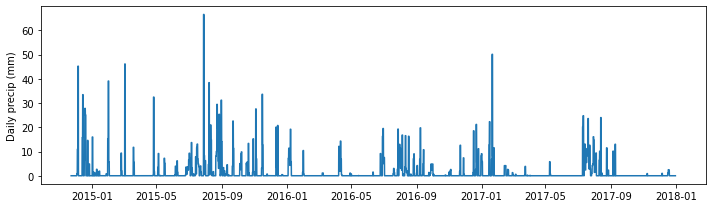

In [4]:
# Plot precip data
start_remove = pd.to_datetime('2017-10-04')
end_remove = pd.to_datetime('2017-11-17')
fig, ax = plt.subplots(figsize=(10,3), tight_layout=True)

ax.plot(df.index, df['PRISM_precip.mm'])
ax.set(ylabel='Daily precip (mm)');

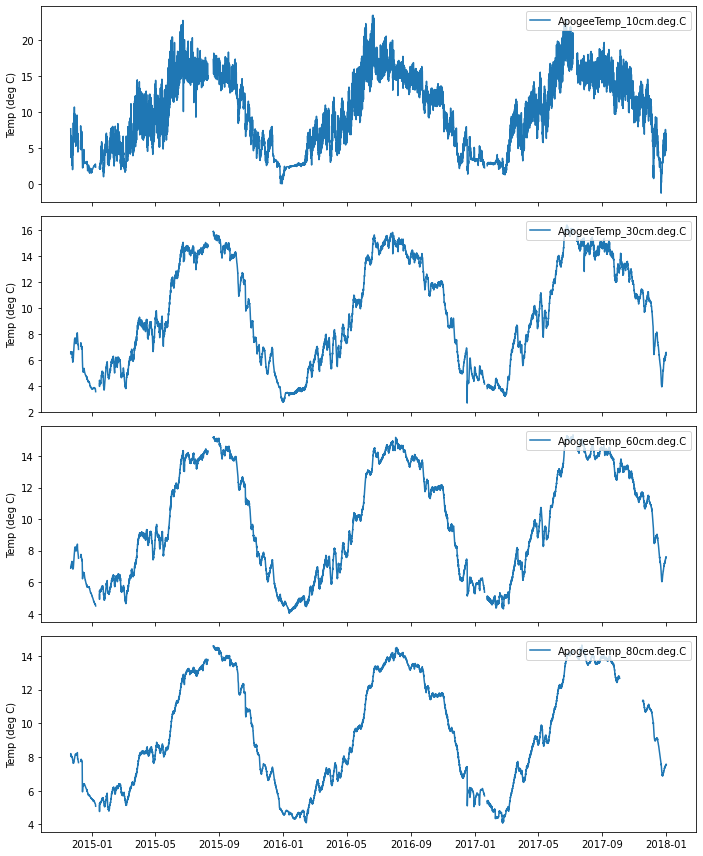

In [5]:
# Plot apogee thermistor temperature
df['ApogeeTemp_80cm.deg.C']=df['ApogeeTemp_80cm.deg.C'].loc[(df.index < start_remove) | (df.index > end_remove)]

apogee_temp_cols = [col for col in df.columns if 'ApogeeTemp' in col]
plot_cols(apogee_temp_cols, ylabel='Temp (deg C)');

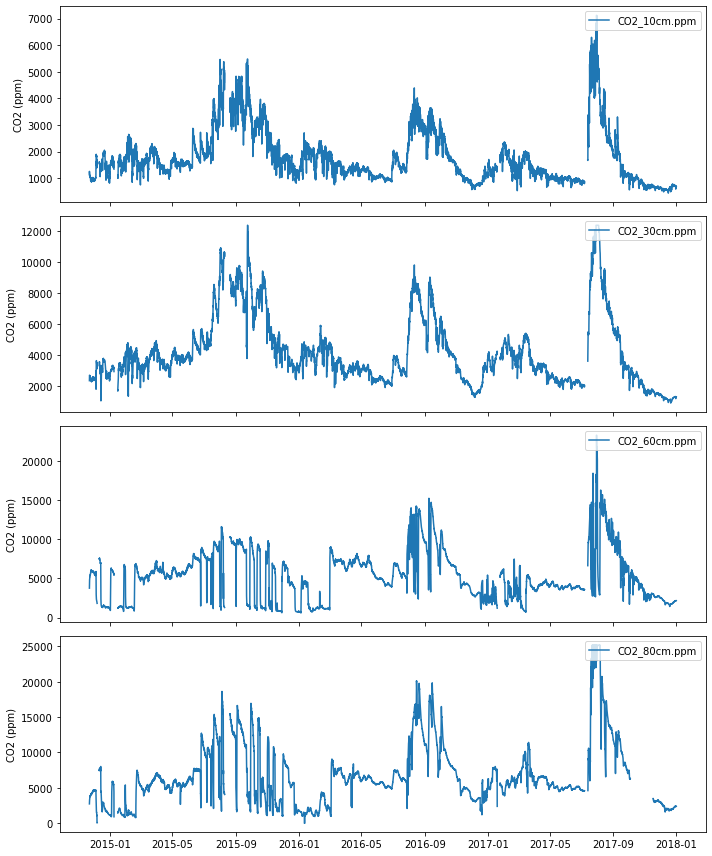

In [6]:
# Plot CO2 data
df['CO2_80cm.ppm']=df['CO2_80cm.ppm'].loc[(df.index < start_remove) | (df.index > end_remove)]

co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

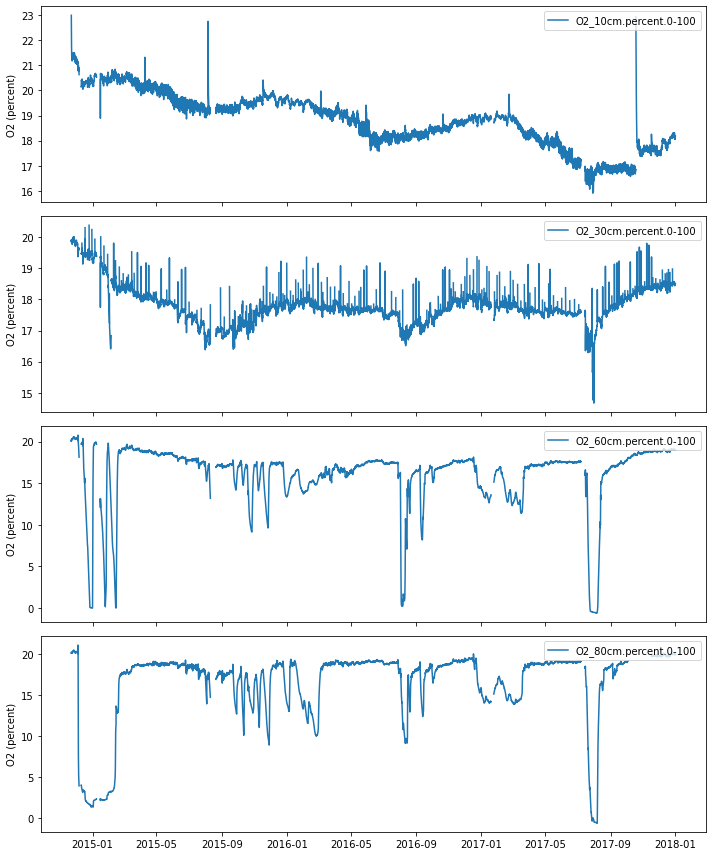

In [7]:
# Plot O2 data
df['O2_80cm.percent.0-100']=df['O2_80cm.percent.0-100'].loc[(df.index < start_remove) | (df.index > end_remove)]
df['O2_10cm.percent.0-100'].mask(df['O2_10cm.percent.0-100']>=23, inplace=True)
df['O2_30cm.percent.0-100'].mask(df['O2_30cm.percent.0-100']>=23, inplace=True)

remove_spikes(df, 'O2_30cm.percent.0-100', window=5, threshold=1.5)

o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

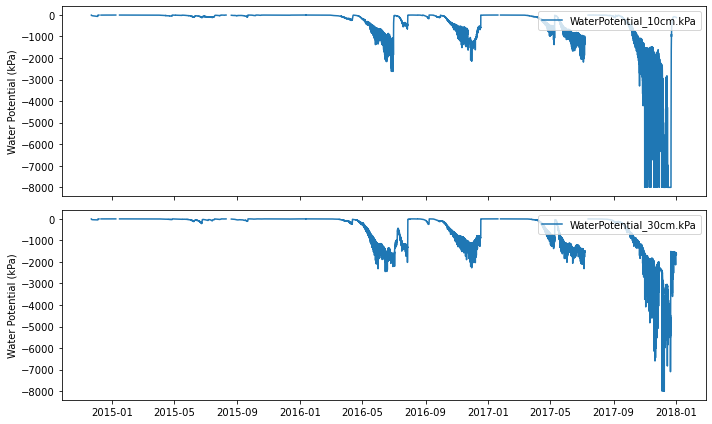

In [8]:
#Plot water potential
water_cols = [col for col in df.columns if 'Water' in col]
plot_cols(water_cols, ylabel='Water Potential (kPa)');

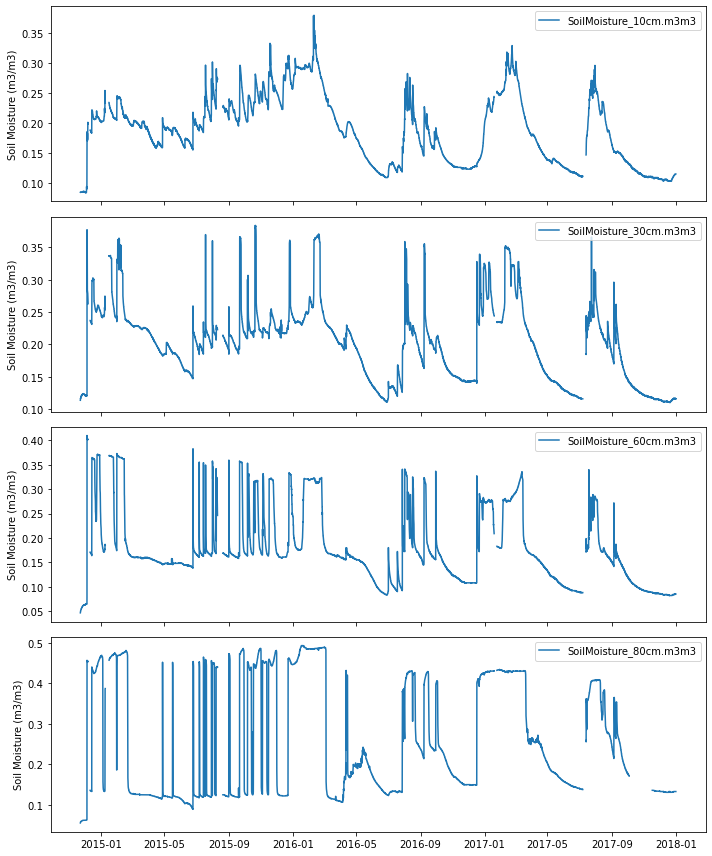

In [9]:
# Plot soil moisture data
df['SoilMoisture_80cm.m3m3']=df['SoilMoisture_80cm.m3m3'].loc[(df.index < start_remove) | (df.index > end_remove)]

sm_cols = [col for col in df.columns if 'SoilMoisture' in col]
plot_cols(sm_cols, ylabel='Soil Moisture (m3/m3)');

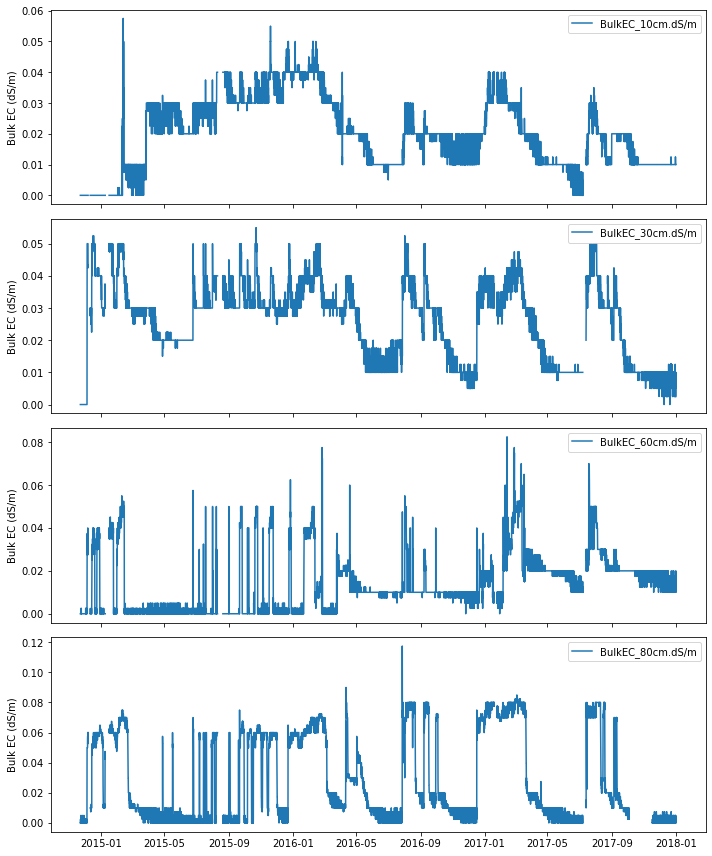

In [10]:
# Plot bulk EC
df['BulkEC_80cm.dS/m']=df['BulkEC_80cm.dS/m'].loc[(df.index < start_remove) | (df.index > end_remove)]

ec_cols = [col for col in df.columns if 'BulkEC' in col]
plot_cols(ec_cols, ylabel='Bulk EC (dS/m)');

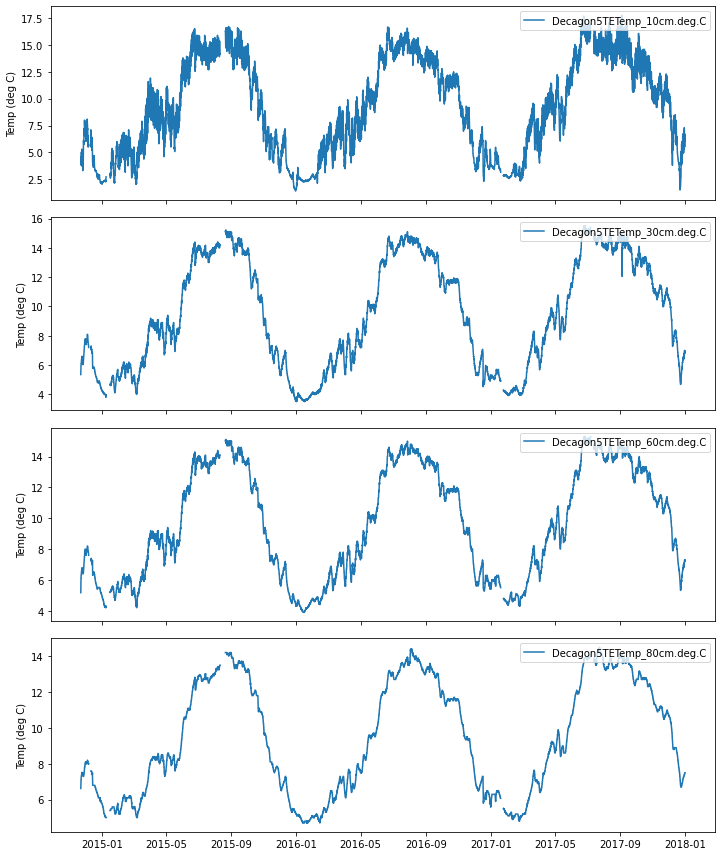

In [11]:
# Plot soil temperature from Decagon 5TE
dec_temp_cols = [col for col in df.columns if 'Decagon5TETemp' in col]

# There are several erroneous values less than -5 deg C
for col in dec_temp_cols:
    df[df[col] < -5] = np.nan
plot_cols(dec_temp_cols, ylabel='Temp (deg C)');

In [12]:
df=df.drop(columns='Decagon5TETemp_10cm.deg.C')
df=df.drop(columns='Decagon5TETemp_30cm.deg.C')
df=df.drop(columns='Decagon5TETemp_60cm.deg.C')
df=df.drop(columns='Decagon5TETemp_80cm.deg.C')

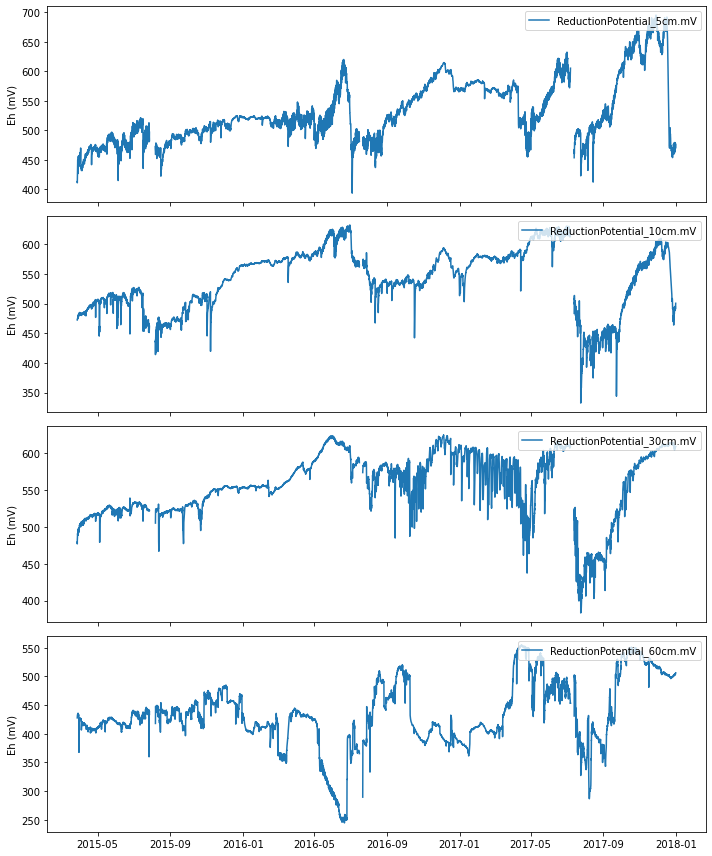

In [13]:
# Plot redox potential

eh_cols = [col for col in df.columns if 'ReductionPotential' in col]
plot_cols(eh_cols, ylabel='Eh (mV)');

In [14]:
df=df.drop(columns='ReductionPotential_5cm.mV')

In [15]:
output=df.copy()
outfile = '../../processed_data/Catalina-Jemez/BGZOB_Pit4_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.MST')

In [16]:
output

,ApogeeTemp_10cm.deg.C,ApogeeTemp_30cm.deg.C,ApogeeTemp_60cm.deg.C,ApogeeTemp_80cm.deg.C,O2_10cm.percent.0-100,O2_30cm.percent.0-100,O2_60cm.percent.0-100,O2_80cm.percent.0-100,CO2_10cm.ppm,CO2_30cm.ppm,...,SoilMoisture_60cm.m3m3,SoilMoisture_80cm.m3m3,BulkEC_10cm.dS/m,BulkEC_30cm.dS/m,BulkEC_60cm.dS/m,BulkEC_80cm.dS/m,ReductionPotential_10cm.mV,ReductionPotential_30cm.mV,ReductionPotential_60cm.mV,PRISM_precip.mm
2014-11-21 14:00:00,7.66900,6.55525,6.88550,8.14050,NaN,19.89725,20.02725,20.12225,1130.09875,2329.20625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-21 15:00:00,6.56300,6.65000,6.97975,8.20700,NaN,19.90225,20.09000,20.21800,1254.72175,2483.02675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-21 16:00:00,6.04075,6.64250,6.96250,8.18125,NaN,19.87125,20.10975,20.20825,1239.52775,2576.89150,...,0.04650,0.05550,0.00,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN
2014-11-21 17:00:00,5.50800,6.63750,6.95075,8.16050,NaN,19.85050,20.11950,20.21275,1234.71200,2631.67675,...,0.04700,0.05600,0.00,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN
2014-11-21 18:00:00,5.24875,6.63625,6.94650,8.14575,NaN,19.85025,20.09725,20.21400,1223.32575,2672.65075,...,0.04725,0.05625,0.00,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,5.87475,6.54650,7.55300,7.54750,18.16725,18.47375,18.98100,19.95900,690.34575,1282.71800,...,0.08500,0.13300,0.01,0.0100,0.0150,0.0000,495.425,609.450,505.700,NaN
2017-12-31 20:00:00,5.70250,6.56875,7.56500,7.55025,18.17650,18.47325,18.98550,19.95800,690.96050,1283.28750,...,0.08500,0.13300,0.01,0.0050,0.0100,0.0000,496.825,609.550,506.025,NaN
2017-12-31 21:00:00,5.65750,6.57875,7.57000,7.54750,18.17850,18.48400,18.99775,19.96000,684.63100,1281.39775,...,0.08500,0.13300,0.01,0.0075,0.0200,0.0000,497.900,609.625,505.950,NaN
2017-12-31 22:00:00,5.53150,6.58325,7.57775,7.55100,18.18625,18.50875,18.99825,19.96525,684.47150,1280.35025,...,0.08500,0.13300,0.01,0.0100,0.0175,0.0025,499.175,609.700,506.250,NaN
